# Homework - Attacks and Defenses in Federated Learning
In this assignment, we will further explore the impact of various attacks and corresponding defenses within the context of federated learning. 

# Instructions

Submit your assignment as a Jupyter notebook with all relevant execution outputs and plots visible. Clearly indicate the relevant steps in your code, such as data preprocessing, model definition, training, etc. Partial grades can be given for incomplete problems provided the steps are clearly indicated.

## Question 1: Influence of Non-I.I.D. Data in Attacks and Defenses (4 points)

Using the template code from [lab-attacks.ipynb](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/lab-attacks.ipynb), experiment with how non-i.i.d. data distributions influence the performance of attacks and defenses. Utilize the `AttackerGradientReversion` for the attack. Keep all hyperparameters the same as those in the template code, except modify the data distribution among the clients to be non-i.i.d.

### Scoring:

- _(1 point)_ Generate test accuracy for 10 rounds, both when there is no defense and when the defenses are `krum`, `multi_krum`, and `majority_sign`. 
- _(1 point)_ Compile the results of these runs into one plot to visually compare the influence of each defense mechanism under non-i.i.d. conditions.
- _(2 points)_ Discuss the differences (if any) between the results in i.i.d. and non-i.i.d. settings for each defense mechanism. 

In [2]:
from base import *
import pandas as pd
import seaborn as sns

sample_split_iid = split(100, True, 42)
sample_split_non_iid = split(100, False, 42)

### Define FedAvgGradServer

In [3]:
class GradWeightClient(Client):
    def __init__(
        self, client_data: Subset, lr: float, batch_size: int, nr_epochs: int
    ) -> None:
        super().__init__(client_data, batch_size)
        self.optimizer = SGD(params=self.model.parameters(), lr=lr)
        self.nr_epochs = nr_epochs

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        self.generator.manual_seed(seed)

        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]

        for _epoch in range(self.nr_epochs):
            train_epoch(self.model, self.loader_train, self.optimizer)

        # Calculate gradients: initial_weights - final_weights
        gradients = [
            initial_weight - final_weight
            for final_weight, initial_weight in zip(
                self.model.parameters(), initial_weights
            )
        ]
        return [gradient.detach().cpu().clone() for gradient in gradients]


class FedAvgGradServer(DecentralizedServer):
    def __init__(
        self,
        lr: float,
        batch_size: int,
        client_subsets: list[Subset],
        client_fraction: float,
        nr_local_epochs: int,
        seed: int,
        name: str,
    ) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, seed)
        self.name = name
        self.nr_local_epochs = nr_local_epochs
        self.clients = [
            GradWeightClient(subset, lr, batch_size, nr_local_epochs)
            for subset in client_subsets
        ]

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.0
        run_result = RunResult(
            self.name,
            self.nr_clients,
            self.client_fraction,
            self.batch_size,
            self.nr_local_epochs,
            self.lr,
            self.seed,
        )

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]

        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            # Other code remains the same until the aggregation part
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False
            )
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients
            )
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.0

            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = (
                    self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                )
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append(
                    [
                        self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                        for tens in client_weights
                    ]
                )
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_gradients: list[torch.Tensor] = [
                sum(x) for x in zip(*chosen_adjusted_weights)
            ]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(
                        device=device
                    )  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(
                    self.model.parameters(), server_weights
                ):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(
                2 * (nr_round + 1) * self.nr_clients_per_round
            )
            run_result.test_accuracy.append(self.test())

        return run_result

### Define AttackerGradientReversion

In [4]:
class AttackerGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Reverse the gradients: for a malicious client, negate the weights to simulate an attack
        reversed_gradients = [-5 * w for w in honest_gradients]

        return reversed_gradients

### Define Krum, Multi-Krum and Majority Sign

In [5]:
def krum(clients_updates, n=20, m=4):
    # Number of neighboring updates to consider
    n_neighbors = n - m - 2
    scores = []

    # Calculate the score for each update
    for i in range(len(clients_updates)):
        distances = []
        for j in range(len(clients_updates)):
            if i != j:
                # Compute squared l2 distance between updates
                distance = sum(
                    (param_i - param_j).pow(2).sum()
                    for param_i, param_j in zip(
                        clients_updates[i][1], clients_updates[j][1]
                    )
                )
                distances.append(distance)

        # Get the n_neighbors smallest distances
        nearest_distances = sorted(distances)[:n_neighbors]
        # Sum of these distances is the score of this client's update
        scores.append(sum(nearest_distances))

    # Select the index with the smallest score
    selected_index = scores.index(min(scores))
    return [selected_index]


def multi_krum(clients_updates, k=14, n=20, m=5):
    selected_indices = []
    remaining_updates = clients_updates[:]

    for i in range(k):
        # Apply Krum to the remaining updates and get the index of the best gradient
        selected_index = krum(remaining_updates, n - i, m)[0]

        # Map selected index from remaining_updates back to the original clients_updates
        original_index = clients_updates.index(remaining_updates[selected_index])
        selected_indices.append(original_index)

        # Remove the selected update from remaining_updates
        remaining_updates.pop(selected_index)

    return selected_indices


def majority_sign_filter(all_updates):
    # 'all_updates' is a list of lists of torch.Tensor objects,
    # where each inner list contains the gradients for all parameters from one client.

    # Step 1: Transpose the list to group gradients of the same parameter together
    parameter_wise_updates = list(zip(*all_updates))

    # Step 2: Calculate sign and count for determining majority
    all_signs = [
        torch.sign(torch.stack(parameter_group, dim=0))
        for parameter_group in parameter_wise_updates
    ]

    # Step 3: Determine the majority sign for each parameter coordinate
    majority_signs = [torch.sign(torch.sum(signs, dim=0)) for signs in all_signs]

    # Step 4: Filter out gradients whose signs don't match the majority
    filtered_updates = []
    for idx, parameter_group in enumerate(parameter_wise_updates):
        majority_sign = majority_signs[idx]
        zeroed_gradients = []

        for gradient in parameter_group:
            gradient_signs = torch.sign(gradient)
            # Zero out gradients where the sign does not match the majority
            gradient[gradient_signs != majority_sign] = 0
            zeroed_gradients.append(gradient)

        # Step 5: Calculate the average of the filtered gradients
        filtered_average = torch.mean(torch.stack(zeroed_gradients), dim=0)
        filtered_updates.append(filtered_average * 20)

    return filtered_updates

### Define FedAvgServerDefense

In [6]:
class FedAvgServerDefense(FedAvgGradServer):
    def __init__(
        self,
        lr: float,
        batch_size: int,
        client_subsets: list,
        client_fraction: float,
        nr_local_epochs: int,
        seed: int,
        name: str,
        defense=None,
    ):
        super().__init__(
            lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed, name
        )
        self.defense_method = defense

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.0
        run_result = RunResult(
            self.name,
            self.nr_clients,
            self.client_fraction,
            self.batch_size,
            self.nr_local_epochs,
            self.lr,
            self.seed,
        )

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False
            )
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients
            )
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.0

            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = (
                    self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                )
                client_weights = self.clients[ind].update(weights, client_round_seed)
                client_updates.append((ind, client_weights))
                update_time = max(update_time, perf_counter() - update_start_time)
            if self.defense_method:
                selected_indices = self.defense_method(client_updates)
            else:
                selected_indices = range(
                    len(client_updates)
                )  # Use all updates if no defense is specified
            print(
                f"The following indices are selected in the training {np.sort(indices_chosen_clients[selected_indices])}"
            )
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i]
                for i in indices_chosen_clients[selected_indices]
            )
            chosen_adjusted_weights = [
                [
                    self.client_sample_counts[indices_chosen_clients[ind]]
                    / chosen_sum_nr_samples
                    * tens
                    for tens in client_updates[ind][1]
                ]
                for ind in selected_indices
            ]
            # Aggregation logic remains the same from this point onwards
            # Note that chosen_adjusted_weights now only contains updates from clients selected by multi_krum
            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_gradients: list[torch.Tensor] = [
                sum(x) for x in zip(*chosen_adjusted_weights)
            ]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(
                        device=device
                    )  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(
                    self.model.parameters(), server_weights
                ):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(
                2 * (nr_round + 1) * self.nr_clients_per_round
            )
            run_result.test_accuracy.append(self.test())

        return run_result

### Define FedAvgServerDefenseCoordinate

In [7]:
class FedAvgServerDefenseCoordinate(FedAvgGradServer):
    def __init__(
        self,
        lr: float,
        batch_size: int,
        client_subsets: list,
        client_fraction: float,
        nr_local_epochs: int,
        seed: int,
        name: str,
        defense=None,
    ):
        super().__init__(
            lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed, name
        )
        self.defense_method = defense

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.0
        run_result = RunResult(
            self.name,
            self.nr_clients,
            self.client_fraction,
            self.batch_size,
            self.nr_local_epochs,
            self.lr,
            self.seed,
        )

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False
            )
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients
            )
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.0

            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = (
                    self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                )
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append(
                    [
                        self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                        for tens in client_weights
                    ]
                )
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            if self.defense_method:
                averaged_gradients = self.defense_method(chosen_adjusted_weights)
            else:
                averaged_gradients: list[torch.Tensor] = [
                    sum(x) for x in zip(*chosen_adjusted_weights)
                ]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(
                        device=device
                    )  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(
                    self.model.parameters(), server_weights
                ):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(
                2 * (nr_round + 1) * self.nr_clients_per_round
            )
            run_result.test_accuracy.append(self.test())

        return run_result

### Run without defense

In [7]:
fedavg_server_reverse = FedAvgGradServer(
    0.02, 200, sample_split_non_iid, 0.2, 2, 42, "Non-IID: Without Defense"
)
clients = fedavg_server_reverse.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_reverse = fedavg_server_reverse.run(10)
fedavg_df_reverse_non_iid = result_fedavg_reverse.as_df()
fedavg_df_reverse_non_iid

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,Non-IID: Without Defense,100,0.2,200,2,0.02,42,40,6.96
1,2,Non-IID: Without Defense,100,0.2,200,2,0.02,42,80,18.90
2,3,Non-IID: Without Defense,100,0.2,200,2,0.02,42,120,9.82
3,4,Non-IID: Without Defense,100,0.2,200,2,0.02,42,160,9.82
4,5,Non-IID: Without Defense,100,0.2,200,2,0.02,42,200,9.83
5,6,Non-IID: Without Defense,100,0.2,200,2,0.02,42,240,10.34
6,7,Non-IID: Without Defense,100,0.2,200,2,0.02,42,280,18.82
7,8,Non-IID: Without Defense,100,0.2,200,2,0.02,42,320,14.96
8,9,Non-IID: Without Defense,100,0.2,200,2,0.02,42,360,10.36
9,10,Non-IID: Without Defense,100,0.2,200,2,0.02,42,400,19.47


In [8]:
fedavg_server_reverse = FedAvgGradServer(
    0.02, 200, sample_split_iid, 0.2, 2, 42, "IID: Without Defense"
)
clients = fedavg_server_reverse.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_reverse = fedavg_server_reverse.run(10)
fedavg_df_reverse_iid = result_fedavg_reverse.as_df()
fedavg_df_reverse_iid

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,IID: Without Defense,100,0.2,200,2,0.02,42,40,3.06
1,2,IID: Without Defense,100,0.2,200,2,0.02,42,80,2.84
2,3,IID: Without Defense,100,0.2,200,2,0.02,42,120,5.48
3,4,IID: Without Defense,100,0.2,200,2,0.02,42,160,6.24
4,5,IID: Without Defense,100,0.2,200,2,0.02,42,200,8.08
5,6,IID: Without Defense,100,0.2,200,2,0.02,42,240,6.51
6,7,IID: Without Defense,100,0.2,200,2,0.02,42,280,8.41
7,8,IID: Without Defense,100,0.2,200,2,0.02,42,320,9.51
8,9,IID: Without Defense,100,0.2,200,2,0.02,42,360,8.73
9,10,IID: Without Defense,100,0.2,200,2,0.02,42,400,8.46


### Run Krum

In [9]:
fedavg_server = FedAvgServerDefense(
    0.02, 200, sample_split_non_iid, 0.2, 2, 42, "Non-IID: Krum", defense=krum
)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
# Replace the selected clients with instances of AttackerGradientInversion
print(f"the following is the malicious indices: {np.sort(malicious_indices)}")
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_krum = fedavg_server.run(10)
fedavg_df_krum_non_iid = result_fedavg_krum.as_df()
fedavg_df_krum_non_iid

the following is the malicious indices: [ 7 23 24 28 30 32 35 37 44 45 56 60 64 68 75 82 85 89 95 99]


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [73]


Rounds:  10%|█         | 1/10 [00:04<00:41,  4.62s/it]

The following indices are selected in the training [15]


Rounds:  20%|██        | 2/10 [00:09<00:36,  4.60s/it]

The following indices are selected in the training [69]


Rounds:  30%|███       | 3/10 [00:13<00:32,  4.63s/it]

The following indices are selected in the training [69]


Rounds:  40%|████      | 4/10 [00:18<00:28,  4.74s/it]

The following indices are selected in the training [73]


Rounds:  50%|█████     | 5/10 [00:23<00:23,  4.77s/it]

The following indices are selected in the training [73]


Rounds:  60%|██████    | 6/10 [00:28<00:19,  4.79s/it]

The following indices are selected in the training [55]


Rounds:  70%|███████   | 7/10 [00:33<00:14,  4.75s/it]

The following indices are selected in the training [15]


Rounds:  80%|████████  | 8/10 [00:37<00:09,  4.73s/it]

The following indices are selected in the training [55]


Rounds:  90%|█████████ | 9/10 [00:42<00:04,  4.76s/it]

The following indices are selected in the training [3]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,Non-IID: Krum,100,0.2,200,2,0.02,42,40,11.71
1,2,Non-IID: Krum,100,0.2,200,2,0.02,42,80,10.10
2,3,Non-IID: Krum,100,0.2,200,2,0.02,42,120,18.27
3,4,Non-IID: Krum,100,0.2,200,2,0.02,42,160,18.39
4,5,Non-IID: Krum,100,0.2,200,2,0.02,42,200,20.80
5,6,Non-IID: Krum,100,0.2,200,2,0.02,42,240,25.39
6,7,Non-IID: Krum,100,0.2,200,2,0.02,42,280,22.29
7,8,Non-IID: Krum,100,0.2,200,2,0.02,42,320,12.36
8,9,Non-IID: Krum,100,0.2,200,2,0.02,42,360,19.38
9,10,Non-IID: Krum,100,0.2,200,2,0.02,42,400,19.08


In [10]:
fedavg_server = FedAvgServerDefense(
    0.02, 200, sample_split_iid, 0.2, 2, 42, "IID: Krum", defense=krum
)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
# Replace the selected clients with instances of AttackerGradientInversion
print(f"the following is the malicious indices: {np.sort(malicious_indices)}")
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_krum = fedavg_server.run(10)
fedavg_df_krum_iid = result_fedavg_krum.as_df()
fedavg_df_krum_iid

the following is the malicious indices: [ 3  9 13 15 17 20 26 31 35 47 48 54 64 68 71 72 78 83 87 96]


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [49]


Rounds:  10%|█         | 1/10 [00:04<00:44,  4.91s/it]

The following indices are selected in the training [4]


Rounds:  20%|██        | 2/10 [00:09<00:39,  4.92s/it]

The following indices are selected in the training [37]


Rounds:  30%|███       | 3/10 [00:14<00:34,  4.96s/it]

The following indices are selected in the training [75]


Rounds:  40%|████      | 4/10 [00:19<00:29,  4.92s/it]

The following indices are selected in the training [37]


Rounds:  50%|█████     | 5/10 [00:24<00:24,  4.89s/it]

The following indices are selected in the training [25]


Rounds:  60%|██████    | 6/10 [00:29<00:19,  4.91s/it]

The following indices are selected in the training [8]


Rounds:  70%|███████   | 7/10 [00:34<00:14,  4.93s/it]

The following indices are selected in the training [40]


Rounds:  80%|████████  | 8/10 [00:39<00:09,  4.94s/it]

The following indices are selected in the training [92]


Rounds:  90%|█████████ | 9/10 [00:44<00:04,  4.93s/it]

The following indices are selected in the training [81]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,IID: Krum,100,0.2,200,2,0.02,42,40,17.76
1,2,IID: Krum,100,0.2,200,2,0.02,42,80,49.50
2,3,IID: Krum,100,0.2,200,2,0.02,42,120,66.34
3,4,IID: Krum,100,0.2,200,2,0.02,42,160,71.99
4,5,IID: Krum,100,0.2,200,2,0.02,42,200,75.59
5,6,IID: Krum,100,0.2,200,2,0.02,42,240,80.10
6,7,IID: Krum,100,0.2,200,2,0.02,42,280,80.85
7,8,IID: Krum,100,0.2,200,2,0.02,42,320,83.27
8,9,IID: Krum,100,0.2,200,2,0.02,42,360,81.58
9,10,IID: Krum,100,0.2,200,2,0.02,42,400,81.43


### Run Multi-Krum

In [11]:
fedavg_server = FedAvgServerDefense(
    0.02, 200, sample_split_non_iid, 0.2, 2, 42, "Non-IID: Multi-Krum", defense=multi_krum
)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
print(f"The following is the malicious indices: {np.sort(malicious_indices)}")
# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_multi_krum = fedavg_server.run(10)
fedavg_df_multi_krum_non_iid = result_fedavg_multi_krum.as_df()
fedavg_df_multi_krum_non_iid

The following is the malicious indices: [ 8 17 25 29 31 35 37 41 43 45 48 54 71 76 80 83 84 85 89 96]


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [ 7 12 17 36 47 49 61 63 68 73 75 83 84 94]


Rounds:  10%|█         | 1/10 [00:06<00:55,  6.17s/it]

The following indices are selected in the training [ 5 13 34 39 44 51 53 58 61 62 69 70 74 79]


Rounds:  20%|██        | 2/10 [00:11<00:46,  5.87s/it]

The following indices are selected in the training [ 8 13 23 28 36 40 61 68 69 75 78 79 87 97]


Rounds:  30%|███       | 3/10 [00:17<00:40,  5.74s/it]

The following indices are selected in the training [ 7  8  9 11 20 30 50 52 53 56 59 69 75 94]


Rounds:  40%|████      | 4/10 [00:23<00:34,  5.81s/it]

The following indices are selected in the training [ 2 10 15 29 35 46 57 65 68 70 73 74 87 94]


Rounds:  50%|█████     | 5/10 [00:29<00:29,  5.81s/it]

The following indices are selected in the training [ 7  9 24 25 28 44 62 69 70 73 79 90 93 99]


Rounds:  60%|██████    | 6/10 [00:34<00:22,  5.73s/it]

The following indices are selected in the training [ 3  7 12 17 26 32 36 39 51 53 55 58 74 93]


Rounds:  70%|███████   | 7/10 [00:40<00:17,  5.90s/it]

The following indices are selected in the training [ 5  7 24 26 34 39 40 44 66 77 79 87 91 95]


Rounds:  80%|████████  | 8/10 [00:46<00:11,  5.84s/it]

The following indices are selected in the training [ 3  9 13 20 22 23 28 55 62 67 81 89 90 92]


Rounds:  90%|█████████ | 9/10 [00:52<00:05,  5.93s/it]

The following indices are selected in the training [ 2  3 13 20 24 30 33 36 49 66 81 83 90 98]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,Non-IID: Multi-Krum,100,0.2,200,2,0.02,42,40,14.46
1,2,Non-IID: Multi-Krum,100,0.2,200,2,0.02,42,80,14.19
2,3,Non-IID: Multi-Krum,100,0.2,200,2,0.02,42,120,9.74
3,4,Non-IID: Multi-Krum,100,0.2,200,2,0.02,42,160,16.93
4,5,Non-IID: Multi-Krum,100,0.2,200,2,0.02,42,200,19.11
5,6,Non-IID: Multi-Krum,100,0.2,200,2,0.02,42,240,18.71
6,7,Non-IID: Multi-Krum,100,0.2,200,2,0.02,42,280,10.39
7,8,Non-IID: Multi-Krum,100,0.2,200,2,0.02,42,320,29.52
8,9,Non-IID: Multi-Krum,100,0.2,200,2,0.02,42,360,32.99
9,10,Non-IID: Multi-Krum,100,0.2,200,2,0.02,42,400,20.51


In [12]:
fedavg_server = FedAvgServerDefense(
    0.02, 200, sample_split_iid, 0.2, 2, 42, "IID: Multi-Krum", defense=multi_krum
)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
print(f"The following is the malicious indices: {np.sort(malicious_indices)}")
# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_multi_krum = fedavg_server.run(10)
fedavg_df_multi_krum_iid = result_fedavg_multi_krum.as_df()
fedavg_df_multi_krum_iid

The following is the malicious indices: [ 7 13 14 18 23 25 29 34 35 44 53 58 59 62 71 81 83 85 87 90]


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [12 17 36 49 54 61 63 68 73 75 84 86 89 94]


Rounds:  10%|█         | 1/10 [00:06<00:56,  6.23s/it]

The following indices are selected in the training [ 4  5 13 15 30 39 47 51 61 62 69 70 79 84]


Rounds:  20%|██        | 2/10 [00:12<00:49,  6.16s/it]

The following indices are selected in the training [ 8 28 36 37 40 54 61 68 69 75 76 79 87 97]


Rounds:  30%|███       | 3/10 [00:18<00:41,  5.97s/it]

The following indices are selected in the training [ 7  9 11 20 30 36 40 50 52 60 69 75 77 94]


Rounds:  40%|████      | 4/10 [00:23<00:35,  5.86s/it]

The following indices are selected in the training [ 2 10 15 31 37 41 46 57 65 70 73 84 87 94]


Rounds:  50%|█████     | 5/10 [00:29<00:28,  5.76s/it]

The following indices are selected in the training [ 9 24 25 28 41 43 62 69 70 73 77 79 93 99]


Rounds:  60%|██████    | 6/10 [00:35<00:22,  5.72s/it]

The following indices are selected in the training [ 3 12 17 26 32 36 39 48 51 53 57 70 74 89]


Rounds:  70%|███████   | 7/10 [00:40<00:17,  5.73s/it]

The following indices are selected in the training [ 5 15 24 26 34 39 40 43 52 54 66 77 91 95]


Rounds:  80%|████████  | 8/10 [00:46<00:11,  5.73s/it]

The following indices are selected in the training [ 3  9 13 20 22 28 37 54 55 67 84 89 92 98]


Rounds:  90%|█████████ | 9/10 [00:52<00:05,  5.77s/it]

The following indices are selected in the training [ 2  3 20 30 33 36 45 49 66 76 77 83 84 98]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,IID: Multi-Krum,100,0.2,200,2,0.02,42,40,20.64
1,2,IID: Multi-Krum,100,0.2,200,2,0.02,42,80,11.13
2,3,IID: Multi-Krum,100,0.2,200,2,0.02,42,120,48.44
3,4,IID: Multi-Krum,100,0.2,200,2,0.02,42,160,62.55
4,5,IID: Multi-Krum,100,0.2,200,2,0.02,42,200,68.51
5,6,IID: Multi-Krum,100,0.2,200,2,0.02,42,240,67.62
6,7,IID: Multi-Krum,100,0.2,200,2,0.02,42,280,71.07
7,8,IID: Multi-Krum,100,0.2,200,2,0.02,42,320,73.60
8,9,IID: Multi-Krum,100,0.2,200,2,0.02,42,360,74.07
9,10,IID: Multi-Krum,100,0.2,200,2,0.02,42,400,77.89


### Run Majority Sign

In [13]:
fedavg_server = FedAvgServerDefenseCoordinate(
    0.02, 200, sample_split_non_iid, 0.2, 2, 42, "Non-IID: Majority Sign", defense=majority_sign_filter
)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
print(malicious_indices)
# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_majority_sign = fedavg_server.run(10)
fedavg_df_majority_sign_non_iid = result_fedavg_majority_sign.as_df()
fedavg_df_majority_sign_non_iid

[20 45  7 38 46 56 75 70 32 72 41 74 35 63 77 29 95 57 98 51]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,Non-IID: Majority Sign,100,0.2,200,2,0.02,42,40,17.40
1,2,Non-IID: Majority Sign,100,0.2,200,2,0.02,42,80,10.75
2,3,Non-IID: Majority Sign,100,0.2,200,2,0.02,42,120,29.50
3,4,Non-IID: Majority Sign,100,0.2,200,2,0.02,42,160,22.82
4,5,Non-IID: Majority Sign,100,0.2,200,2,0.02,42,200,12.31
5,6,Non-IID: Majority Sign,100,0.2,200,2,0.02,42,240,28.27
6,7,Non-IID: Majority Sign,100,0.2,200,2,0.02,42,280,22.88
7,8,Non-IID: Majority Sign,100,0.2,200,2,0.02,42,320,29.51
8,9,Non-IID: Majority Sign,100,0.2,200,2,0.02,42,360,17.81
9,10,Non-IID: Majority Sign,100,0.2,200,2,0.02,42,400,22.08


In [14]:
fedavg_server = FedAvgServerDefenseCoordinate(
    0.02, 200, sample_split_iid, 0.2, 2, 42, "IID: Majority Sign", defense=majority_sign_filter
)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
print(malicious_indices)
# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg_majority_sign = fedavg_server.run(10)
fedavg_df_majority_sign_iid = result_fedavg_majority_sign.as_df()
fedavg_df_majority_sign_iid

[39 15 75 20 17 79 16 91 90 12 22 33 54  8 60 87 44 36 83 52]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,IID: Majority Sign,100,0.2,200,2,0.02,42,40,19.41
1,2,IID: Majority Sign,100,0.2,200,2,0.02,42,80,45.86
2,3,IID: Majority Sign,100,0.2,200,2,0.02,42,120,61.14
3,4,IID: Majority Sign,100,0.2,200,2,0.02,42,160,70.21
4,5,IID: Majority Sign,100,0.2,200,2,0.02,42,200,73.88
5,6,IID: Majority Sign,100,0.2,200,2,0.02,42,240,76.28
6,7,IID: Majority Sign,100,0.2,200,2,0.02,42,280,77.67
7,8,IID: Majority Sign,100,0.2,200,2,0.02,42,320,75.17
8,9,IID: Majority Sign,100,0.2,200,2,0.02,42,360,78.55
9,10,IID: Majority Sign,100,0.2,200,2,0.02,42,400,79.47


### Plot graph

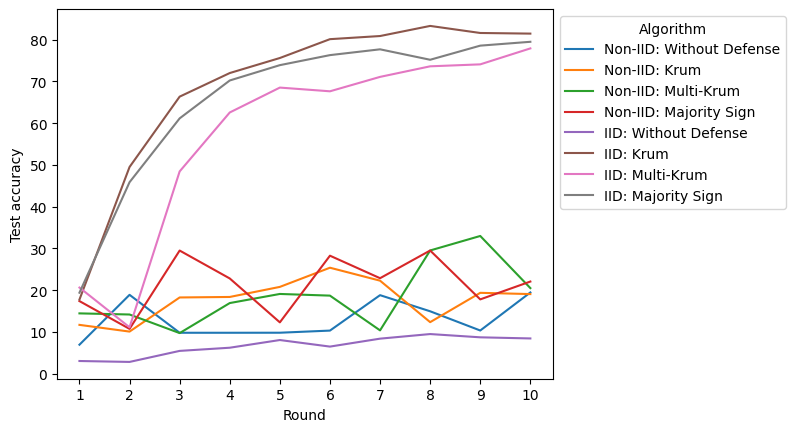

In [17]:
df = pd.concat(
    [
        fedavg_df_reverse_non_iid,
        fedavg_df_krum_non_iid,
        fedavg_df_multi_krum_non_iid,
        fedavg_df_majority_sign_non_iid,
        fedavg_df_reverse_iid,
        fedavg_df_krum_iid,
        fedavg_df_multi_krum_iid,
        fedavg_df_majority_sign_iid,
    ],
    ignore_index=True,
)
ax = sns.lineplot(df, x="Round", y="Test accuracy", hue="Algorithm", seed=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
_ = ax.set_xticks(df["Round"].unique())

TODO

## Question 2: Implementing Bulyan Defense (5 points)

[Bulyan defense](https://arxiv.org/abs/1802.07927) combines aspects of `multi-krum` and `trimmed-mean` to protect against sophisticated attacks in federated environments. In this question, you will implement Bulyan by modifying and combining the existing code in the [lab-attacks.ipynb](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/lab-attacks.ipynb).

### Scoring:
- _(1 point)_ Modify the server-side code to integrate a two-step defense process where:
  1. A client-wise defense like `multi-krum` filters out suspicious gradients based on their distance metrics.
  2. A coordinate-wise defense like `trimmed-mean` calculates the mean across the remaining gradients after trimming the extremes.
  
- _(1 point)_ Successfully integrate these two defense mechanisms [`multi-krum`, `trimmed-mean`] to implement the Bulyan.
- _(3 points)_ Evaluate the performance of your implemented Bulyan defense against three types of attacks: `AttackerGradientReversion`, `AttackerPartGradientReversion`, and `AttackerBackdoor`. Vary the defense hyperparameters to make your defense defend against these attacks while keeping the data distribution i.i.d. and the attacker's hyperparameters constant as per the template. Document the performance of your defense strategy against these attacks in your notebook.

### Define Trimmed-Mean

In [8]:
def tr_mean(all_updates, beta=0.4):
    # 'n_attackers' is the number of top and bottom values to exclude from the mean calculation.

    # Transpose the list to group gradients of the same parameter together
    parameter_wise_updates = list(zip(*all_updates))
    n_attackers = int(20 * beta)
    trimmed_mean_gradients = []
    for parameter_group in parameter_wise_updates:
        # Stack gradients to create a new dimension corresponding to clients
        stacked_updates = torch.stack(parameter_group, dim=0)

        # Sort updates along the client dimension
        sorted_updates = torch.sort(stacked_updates, dim=0)[0]
        # Compute mean excluding the top and bottom 'n_attackers' updates
        if n_attackers > 0:
            trimmed_updates = sorted_updates[n_attackers:-n_attackers]
        else:
            trimmed_updates = sorted_updates

        mean_gradient = torch.mean(trimmed_updates, dim=0)
        trimmed_mean_gradients.append(mean_gradient * 20)

    return trimmed_mean_gradients

### Define FedAvgServerDefenseBulyan

In [9]:
class FedAvgServerDefenseBulyan(FedAvgGradServer):
    def __init__(
        self,
        lr: float,
        batch_size: int,
        client_subsets: list,
        client_fraction: float,
        nr_local_epochs: int,
        seed: int,
        name: str,
        def_multi_krum=None,
        def_tr_mean=None,
        k=14,
        n=20,
        m=5,
        beta=0.4,
    ):
        super().__init__(
            lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed, name
        )
        self.def_multi_krum = def_multi_krum
        self.def_tr_mean = def_tr_mean
        self.k = k
        self.n = n
        self.m = m
        self.beta = beta

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.0
        run_result = RunResult(
            self.name,
            self.nr_clients,
            self.client_fraction,
            self.batch_size,
            self.nr_local_epochs,
            self.lr,
            self.seed,
        )

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False
            )
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients
            )
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.0

            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = (
                    self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                )
                client_weights = self.clients[ind].update(weights, client_round_seed)
                client_updates.append((ind, client_weights))
                update_time = max(update_time, perf_counter() - update_start_time)

            if self.def_multi_krum:
                selected_indices = self.def_multi_krum(
                    client_updates, self.k, self.n, self.m
                )
            else:
                selected_indices = range(
                    len(client_updates)
                )  # Use all updates if no defense is specified
            print(
                f"The following indices are selected in the training {np.sort(indices_chosen_clients[selected_indices])}"
            )
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i]
                for i in indices_chosen_clients[selected_indices]
            )
            chosen_adjusted_weights = [
                [
                    self.client_sample_counts[indices_chosen_clients[ind]]
                    / chosen_sum_nr_samples
                    * tens
                    for tens in client_updates[ind][1]
                ]
                for ind in selected_indices
            ]
            # Aggregation logic remains the same from this point onwards
            # Note that chosen_adjusted_weights now only contains updates from clients selected by multi_krum
            elapsed_time += update_time
            aggregate_start_time = perf_counter()

            if self.def_tr_mean:
                averaged_gradients = self.def_tr_mean(
                    chosen_adjusted_weights, self.beta
                )
            else:
                averaged_gradients: list[torch.Tensor] = [
                    sum(x) for x in zip(*chosen_adjusted_weights)
                ]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(
                        device=device
                    )  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(
                    self.model.parameters(), server_weights
                ):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(
                2 * (nr_round + 1) * self.nr_clients_per_round
            )
            run_result.test_accuracy.append(self.test())

        return run_result

### Define AttackerPartGradientReversion

In [10]:
class AttackerPartGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Set random seed for reproducibility
        torch.manual_seed(seed)

        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Flatten the gradients and calculate 10% of the total number of gradient elements
        all_gradients = torch.cat([g.flatten() for g in honest_gradients])
        num_to_manipulate = int(all_gradients.numel())

        # Determine the threshold of parameters to modify
        param_threshold = (
            num_to_manipulate * 0.00001
        )  # Set this to your desired threshold

        # Select the first k layers until the cumulative number of parameters exceeds the threshold
        cumulative_params = 0
        selected_gradients = []
        for gradient in honest_gradients:
            # print(gradient.numel())
            cumulative_params += gradient.numel()
            selected_gradients.append(gradient)
            if cumulative_params >= param_threshold:
                break

        # Multiply the selected gradients by -1000
        for gradient in selected_gradients:
            gradient *= -1000

        return honest_gradients  # Return the modified gradients

### Define AttackerBackdoor

In [11]:
# a new data class that help us to process batch
@dataclass
class Batch:
    batch_id: int
    inputs: torch.Tensor
    labels: torch.Tensor

    def __post_init__(self):
        self.batch_size = self.inputs.shape[0]

    def to(self, device):
        inputs = self.inputs.to(device)
        labels = self.labels.to(device)
        return Batch(self.batch_id, inputs, labels)

    def clone(self):
        inputs = self.inputs.clone()
        labels = self.labels.clone()
        return Batch(self.batch_id, inputs, labels)

    def clip(self, batch_size):
        if batch_size is None:
            return self

        inputs = self.inputs[:batch_size]
        labels = self.labels[:batch_size]

        return Batch(self.batch_id, inputs, labels)


class Synthesizer:
    def __init__(self, poisoning_proportion):
        self.poisoning_proportion = poisoning_proportion

    def make_backdoor_batch(self, batch: Batch, test=False, attack=True) -> Batch:
        if not attack:
            return batch

        if test:
            attack_portion = batch.batch_size
        else:
            attack_portion = round(batch.batch_size * self.poisoning_proportion)

        backdoored_batch = batch.clone()
        self.apply_backdoor(backdoored_batch, attack_portion)
        return backdoored_batch

    def apply_backdoor(self, batch, attack_portion):
        """
        Modifies only a portion of the batch (represents batch poisoning).

        :param batch:
        :return:
        """
        self.synthesize_inputs(batch=batch, attack_portion=attack_portion)
        self.synthesize_labels(batch=batch, attack_portion=attack_portion)

        return

    def synthesize_inputs(self, batch, attack_portion=None):
        raise NotImplemented

    def synthesize_labels(self, batch, attack_portion=None):
        raise NotImplemented


class PatternSynthesizer(Synthesizer):
    pattern_tensor: torch.Tensor = torch.tensor(
        [
            [1.0, 0.0, 1.0],
            [-10.0, 1.0, -10.0],
            [-10.0, -10.0, 0.0],
            [-10.0, 1.0, -10.0],
            [1.0, 0.0, 1.0],
        ]
    )
    "Just some random 2D pattern."

    x_top = 3
    "X coordinate to put the backdoor into."
    y_top = 23
    "Y coordinate to put the backdoor into."

    mask_value = -10
    "A tensor coordinate with this value won't be applied to the image."

    resize_scale = (5, 10)
    "If the pattern is dynamically placed, resize the pattern."

    mask: torch.Tensor = None
    "A mask used to combine backdoor pattern with the original image."

    pattern: torch.Tensor = None
    "A tensor of the `input.shape` filled with `mask_value` except backdoor."

    def __init__(self, poisoning_proportion):
        super().__init__(poisoning_proportion)
        self.input_shape = (1, 28, 28)
        self.backdoor_label = 0
        self.normalize = transforms.Normalize((0.1307,), (0.3081,))
        self.make_pattern(self.pattern_tensor, self.x_top, self.y_top)

    def make_pattern(self, pattern_tensor, x_top, y_top):
        # put pattern into the image
        full_image = torch.zeros(self.input_shape)
        full_image.fill_(self.mask_value)
        # full image has a pixel value of -10
        x_bot = x_top + pattern_tensor.shape[0]
        y_bot = y_top + pattern_tensor.shape[1]

        if x_bot >= self.input_shape[1] or y_bot >= self.input_shape[2]:
            raise ValueError(
                f"Position of backdoor outside image limits:"
                f"image: {self.input_shape}, but backdoor"
                f"ends at ({x_bot}, {y_bot})"
            )

        full_image[:, x_top:x_bot, y_top:y_bot] = pattern_tensor
        # full image has a pixel value of -10 except for the backdoor (pattern_tensor) size: 5 * 3
        self.mask = 1 * (full_image != self.mask_value).to(device)  # (0, 1)
        # mask is a tensor of 0 and 1, 0 for -10 and 1 for other values
        self.pattern = self.normalize(full_image).to(device)  # )(-52.5678, 2.7537)

    def synthesize_inputs(self, batch, attack_portion=None):
        pattern, mask = self.get_pattern()
        # mask value (0, 1); value 0, keep the original image; value 1, replace with pattern
        batch.inputs[:attack_portion] = (1 - mask) * batch.inputs[
            :attack_portion
        ] + mask * pattern

        return

    def synthesize_labels(self, batch, attack_portion=None):
        batch.labels[:attack_portion].fill_(self.backdoor_label)
        return

    def get_pattern(self):
        return self.pattern, self.mask


# Instantiate the synthesizer with a poisoning proportion
poisoning_proportion = 0.5
synthesizer = PatternSynthesizer(poisoning_proportion=poisoning_proportion)


class AttackerBackdoor(GradWeightClient):
    def train_epoch(
        self, model: torch.nn.Module, loader: DataLoader, optimizer: Optimizer
    ) -> None:
        model.train()
        for batch_idx, (inputs, labels) in enumerate(loader):
            batch = Batch(batch_idx, inputs, labels)
            batch = batch.to(device)
            backdoored_batch = synthesizer.make_backdoor_batch(
                batch, test=False, attack=True
            )
            data = backdoored_batch.inputs
            target = backdoored_batch.labels
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        self.generator.manual_seed(seed)

        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]

        for _epoch in range(self.nr_epochs):
            self.train_epoch(self.model, self.loader_train, self.optimizer)

        # Calculate gradients: final_weights - initial_weights
        gradients = [
            5 * (initial_weight - final_weight)
            for final_weight, initial_weight in zip(
                self.model.parameters(), initial_weights
            )
        ]

        return [gradient.detach().cpu().clone() for gradient in gradients]

### Run AttackerGradientReversion

In [53]:
fedavg_server = FedAvgServerDefenseBulyan(
    0.02,
    200,
    sample_split_iid,
    0.2,
    2,
    42,
    "AttackerGradientReversion",
    def_multi_krum=multi_krum,
    def_tr_mean=tr_mean,
    k=10,
    n=25,
    m=4,
    beta=0.2,
)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg = fedavg_server.run(10)
fedavg_df_AttackerGradientReversion = result_fedavg.as_df()
fedavg_df_AttackerGradientReversion

Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [ 7 17 36 47 54 75 83 84 89 94]


Rounds:  10%|█         | 1/10 [00:06<00:55,  6.21s/it]

The following indices are selected in the training [ 4 13 18 39 44 47 51 53 58 62]


Rounds:  20%|██        | 2/10 [00:12<00:51,  6.43s/it]

The following indices are selected in the training [13 23 37 40 54 68 71 75 76 86]


Rounds:  30%|███       | 3/10 [00:19<00:44,  6.37s/it]

The following indices are selected in the training [11 20 36 40 50 52 53 54 75 77]


Rounds:  40%|████      | 4/10 [00:24<00:36,  6.12s/it]

The following indices are selected in the training [ 2  8 10 46 57 65 68 74 87 94]


Rounds:  50%|█████     | 5/10 [00:30<00:29,  5.95s/it]

The following indices are selected in the training [ 7  9 25 43 62 77 81 90 93 99]


Rounds:  60%|██████    | 6/10 [00:36<00:24,  6.00s/it]

The following indices are selected in the training [ 7  8 32 36 53 55 58 74 89 93]


Rounds:  70%|███████   | 7/10 [00:42<00:17,  5.96s/it]

The following indices are selected in the training [ 7 15 24 39 40 43 52 60 66 87]


Rounds:  80%|████████  | 8/10 [00:48<00:11,  5.93s/it]

The following indices are selected in the training [20 21 23 54 55 62 81 89 90 92]


Rounds:  90%|█████████ | 9/10 [00:53<00:05,  5.84s/it]

The following indices are selected in the training [ 3  8 10 13 20 33 76 81 83 90]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,AttackerGradientReversion,100,0.2,200,2,0.02,42,40,40.59
1,2,AttackerGradientReversion,100,0.2,200,2,0.02,42,80,66.65
2,3,AttackerGradientReversion,100,0.2,200,2,0.02,42,120,75.53
3,4,AttackerGradientReversion,100,0.2,200,2,0.02,42,160,82.38
4,5,AttackerGradientReversion,100,0.2,200,2,0.02,42,200,82.01
5,6,AttackerGradientReversion,100,0.2,200,2,0.02,42,240,85.08
6,7,AttackerGradientReversion,100,0.2,200,2,0.02,42,280,86.67
7,8,AttackerGradientReversion,100,0.2,200,2,0.02,42,320,88.54
8,9,AttackerGradientReversion,100,0.2,200,2,0.02,42,360,88.88
9,10,AttackerGradientReversion,100,0.2,200,2,0.02,42,400,90.04


### Run AttackerPartGradientReversion

In [57]:
fedavg_server = FedAvgServerDefenseBulyan(
    0.02,
    200,
    sample_split_iid,
    0.2,
    2,
    42,
    "AttackerPartGradientReversion",
    def_multi_krum=multi_krum,
    def_tr_mean=tr_mean,
    k=10,
    n=20,
    m=4,
    beta=0.2,
)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
print(f"The following is the malicious indices: {np.sort(malicious_indices)}")
# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerPartGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg = fedavg_server.run(10)
fedavg_df_AttackerPartGradientReversion = result_fedavg.as_df()
fedavg_df_AttackerPartGradientReversion

The following is the malicious indices: [ 0  3  4 10 12 22 24 28 31 35 48 51 52 65 73 76 79 81 85 95]


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [17 36 47 49 63 68 75 83 84 89]


Rounds:  10%|█         | 1/10 [00:05<00:51,  5.73s/it]

The following indices are selected in the training [ 5 13 15 30 34 39 62 69 70 84]


Rounds:  20%|██        | 2/10 [00:11<00:45,  5.66s/it]

The following indices are selected in the training [ 8 13 36 37 40 54 68 69 71 97]


Rounds:  30%|███       | 3/10 [00:17<00:40,  5.73s/it]

The following indices are selected in the training [ 7 20 30 40 50 53 54 69 75 77]


Rounds:  40%|████      | 4/10 [00:23<00:34,  5.79s/it]

The following indices are selected in the training [ 2  8 15 41 45 46 57 68 70 87]


Rounds:  50%|█████     | 5/10 [00:28<00:29,  5.85s/it]

The following indices are selected in the training [ 7 41 43 62 69 73 77 83 90 93]


Rounds:  60%|██████    | 6/10 [00:34<00:23,  5.81s/it]

The following indices are selected in the training [ 8 18 26 32 36 53 55 70 89 93]


Rounds:  70%|███████   | 7/10 [00:40<00:17,  5.80s/it]

The following indices are selected in the training [ 5  7 15 39 40 44 45 54 66 87]


Rounds:  80%|████████  | 8/10 [00:46<00:11,  5.85s/it]

The following indices are selected in the training [13 20 21 23 54 55 62 84 90 92]


Rounds:  90%|█████████ | 9/10 [00:52<00:05,  5.86s/it]

The following indices are selected in the training [ 8 13 33 36 45 66 77 83 84 90]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,AttackerPartGradientReversion,100,0.2,200,2,0.02,42,40,43.32
1,2,AttackerPartGradientReversion,100,0.2,200,2,0.02,42,80,70.45
2,3,AttackerPartGradientReversion,100,0.2,200,2,0.02,42,120,73.15
3,4,AttackerPartGradientReversion,100,0.2,200,2,0.02,42,160,82.13
4,5,AttackerPartGradientReversion,100,0.2,200,2,0.02,42,200,83.31
5,6,AttackerPartGradientReversion,100,0.2,200,2,0.02,42,240,86.45
6,7,AttackerPartGradientReversion,100,0.2,200,2,0.02,42,280,87.45
7,8,AttackerPartGradientReversion,100,0.2,200,2,0.02,42,320,88.24
8,9,AttackerPartGradientReversion,100,0.2,200,2,0.02,42,360,88.80
9,10,AttackerPartGradientReversion,100,0.2,200,2,0.02,42,400,89.15


### Run AttackerBackdoor

In [61]:
fedavg_server = FedAvgServerDefenseBulyan(
    0.02,
    200,
    sample_split_iid,
    0.2,
    2,
    42,
    "AttackerBackdoor",
    def_multi_krum=multi_krum,
    def_tr_mean=tr_mean,
    k=12,
    n=20,
    m=4,
    beta=0.2,
)
clients = fedavg_server.clients
# Number of clients to be made malicious with backdoor
num_malicious = int(0.2 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo backdoor attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerBackdoor(client_data, lr, batch_size, nr_epochs)

result_fedavg = fedavg_server.run(10)
fedavg_df_AttackerBackdoor = result_fedavg.as_df()
fedavg_df_AttackerBackdoor

Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [12 36 45 47 49 63 68 71 73 83 89 94]


Rounds:  10%|█         | 1/10 [00:06<00:55,  6.16s/it]

The following indices are selected in the training [ 4  5 13 15 30 34 39 47 53 58 62 69]


Rounds:  20%|██        | 2/10 [00:11<00:47,  5.96s/it]

The following indices are selected in the training [ 8 13 23 28 36 40 68 69 76 79 87 97]


Rounds:  30%|███       | 3/10 [00:17<00:41,  5.91s/it]

The following indices are selected in the training [ 7 11 20 30 36 40 50 52 53 59 69 85]


Rounds:  40%|████      | 4/10 [00:23<00:35,  5.95s/it]

The following indices are selected in the training [ 8 29 31 35 45 57 65 68 70 73 74 87]


Rounds:  50%|█████     | 5/10 [00:29<00:29,  5.94s/it]

The following indices are selected in the training [ 7  9 25 28 31 62 69 70 73 81 90 99]


Rounds:  60%|██████    | 6/10 [00:35<00:23,  5.86s/it]

The following indices are selected in the training [ 3  7  8 26 32 36 51 53 55 57 58 89]


Rounds:  70%|███████   | 7/10 [00:41<00:17,  5.83s/it]

The following indices are selected in the training [ 5  7 15 26 34 39 52 60 66 79 87 95]


Rounds:  80%|████████  | 8/10 [00:47<00:11,  5.83s/it]

The following indices are selected in the training [ 3 20 21 22 28 55 62 67 81 89 90 92]


Rounds:  90%|█████████ | 9/10 [00:53<00:05,  5.87s/it]

The following indices are selected in the training [ 2  3 13 20 30 45 49 66 76 81 83 90]


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,AttackerBackdoor,100,0.2,200,2,0.02,42,40,46.50
1,2,AttackerBackdoor,100,0.2,200,2,0.02,42,80,62.32
2,3,AttackerBackdoor,100,0.2,200,2,0.02,42,120,72.11
3,4,AttackerBackdoor,100,0.2,200,2,0.02,42,160,79.77
4,5,AttackerBackdoor,100,0.2,200,2,0.02,42,200,82.49
5,6,AttackerBackdoor,100,0.2,200,2,0.02,42,240,84.62
6,7,AttackerBackdoor,100,0.2,200,2,0.02,42,280,87.48
7,8,AttackerBackdoor,100,0.2,200,2,0.02,42,320,86.85
8,9,AttackerBackdoor,100,0.2,200,2,0.02,42,360,88.95
9,10,AttackerBackdoor,100,0.2,200,2,0.02,42,400,88.23


### Plot graph

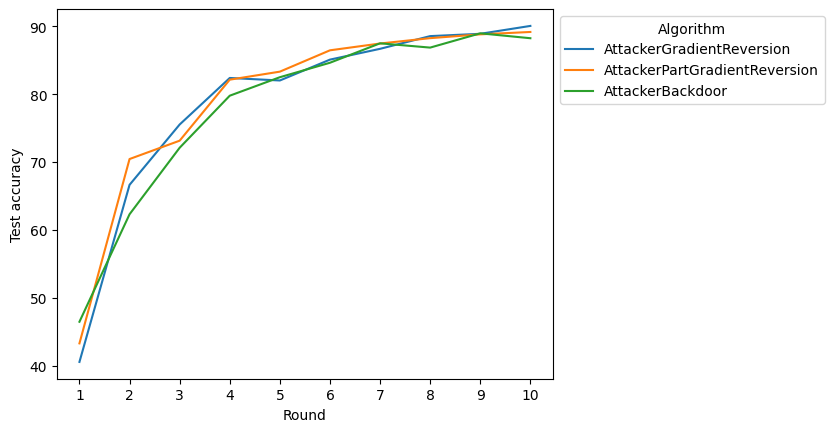

In [62]:
df = pd.concat(
    [
        fedavg_df_AttackerGradientReversion,
        fedavg_df_AttackerPartGradientReversion,
        fedavg_df_AttackerBackdoor,
    ],
    ignore_index=True,
)
ax = sns.lineplot(df, x="Round", y="Test accuracy", hue="Algorithm", seed=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
_ = ax.set_xticks(df["Round"].unique())

TODO

## Question 3: Implementing SparseFed Defense (7 points)

In this exercise, you will implement the [SparseFed Defense](https://arxiv.org/abs/2112.06274). SparseFed Defense involves two main steps for each participating device during the training process:
1. **Clipping the gradient:** Each device clips its gradient to reduce the impact of potentially malicious updates.
2. **Aggregating top-k updates:** During the aggregation phase, only the gradients with the highest magnitudes (top-k) are considered. This method is designed to minimize the risk of model poisoning by excluding anomalous gradient contributions from potentially compromised devices.

### Scoring:
- _(2 points)_ Implement a simplified version of SparseFed based on the clipping code provided in the template notebook. Unlike the original algorithm which includes momentum, you only need to implement the clipping step and the sparsification step. However, ensure that only the top-k coordinates in the aggregated gradients are selected based on their magnitudes. For example, if the aggregated gradient is `[3, -1, -1, -3]`, selecting the top-2 by magnitude should result in `[3, 0, 0, -3]`.

- _(3 points)_ Evaluate the performance of your implemented SparseFed defense against two types of attacks: `AttackerGradientReversion` and `AttackerBackdoor`. Adjust the values of the defense hyperparameter k to optimize defense effectiveness. Ensure the data distribution remains i.i.d., and the attacker's hyperparameters are unchanged from the template. Document and compare the performance of SparseFed to the simple clipping defense across these attack scenarios. Suggested values for k include percentages of the total parameters, such as 20%, 50%, and 80%.

- _(2 points)_ Analyze and discuss the results to determine if SparseFed provided any improvements. Explain why the sparsefication either succeeded or failed in enhancing the model's robustness against the specified attacks. Include this analysis in your notebook.


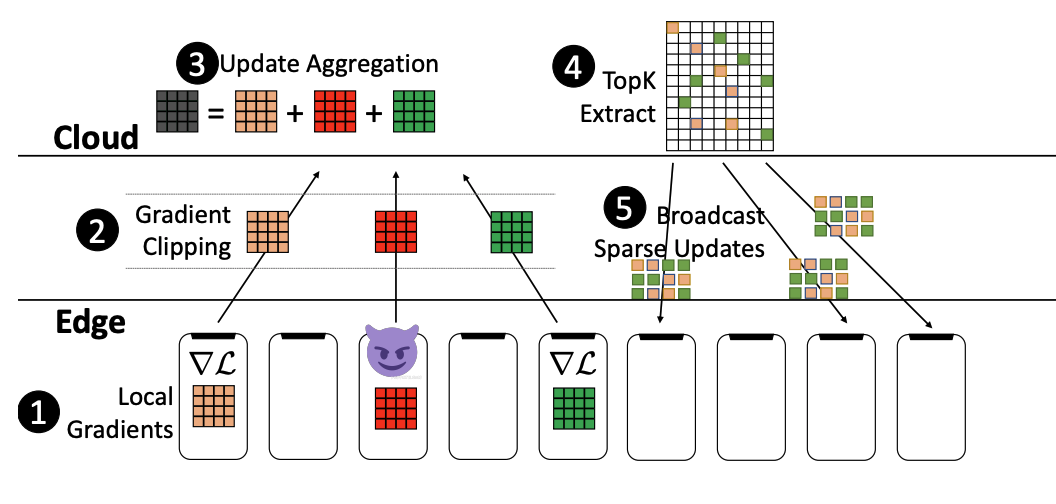


### Define Clipping

In [12]:
def clipping(all_updates, clip_norm_ratio=1.0, noise_std_dev=0.01):
    # 'all_updates' is a list of lists of torch.Tensor objects,
    # where each inner list contains the gradients for all parameters from one client.

    # Step 1: Calculate the norm of each client's update
    norms = [
        torch.norm(torch.stack([torch.norm(p) for p in client_update]))
        for client_update in all_updates
    ]
    average_norm = sum(norms) / len(norms) * clip_norm_ratio

    # Step 2: Clip each client's update
    clipped_updates = []
    for client_update in all_updates:
        clipped_update = []
        client_norm = torch.norm(torch.stack([torch.norm(p) for p in client_update]))
        clip_scale = min(
            1, average_norm / (client_norm + 1e-6)
        )  # Avoid division by zero

        for gradient in client_update:
            clipped_gradient = gradient * clip_scale

            clipped_update.append(clipped_gradient)

        clipped_updates.append(clipped_update)

    # Step 4: Compute the average of these modified gradients
    parameter_wise_updates = list(zip(*clipped_updates))
    averaged_gradients = [
        torch.mean(torch.stack(parameter_group), dim=0) * 20
        for parameter_group in parameter_wise_updates
    ]

    return averaged_gradients

### Define Sparsification

In [144]:
# Source from: https://github.com/sparsefed/sparsefed
def _topk(vec, k):
    """Return the largest k elements (by magnitude) of vec"""
    # on a gpu, sorting is faster than pytorch's topk method
    # topkIndices = torch.sort(vec**2)[1][-k:]
    # however, torch.topk is more space efficient

    # topk on cuda returns what looks like uninitialized memory if
    # vals has nan values in it
    # saving to a zero-initialized output array instead of using the
    # output of topk appears to solve this problem
    topkVals = torch.zeros(k, device=vec.device)
    topkIndices = torch.zeros(k, device=vec.device).long()
    torch.topk(vec**2, k, sorted=False, out=(topkVals, topkIndices))

    ret = torch.zeros_like(vec)
    if len(vec.size()) == 1:
        ret[topkIndices] = vec[topkIndices]
    elif len(vec.size()) == 2:
        rows = torch.arange(vec.size()[0]).view(-1, 1)
        ret[rows, topkIndices] = vec[rows, topkIndices]
    return ret


def sparsification(
    all_updates, clip_norm_ratio=1.0, noise_std_dev=0.01, sparsity_ratio=0.8
):
    # 'all_updates' is a list of lists of torch.Tensor objects,
    # where each inner list contains the gradients for all parameters from one client.

    # Step 1: Calculate the norm of each client's update
    norms = [
        torch.norm(torch.stack([torch.norm(p) for p in client_update]))
        for client_update in all_updates
    ]
    average_norm = sum(norms) / len(norms) * clip_norm_ratio

    # Step 2: Clip each client's update
    clipped_updates = []
    for client_update in all_updates:
        clipped_update = []
        client_norm = torch.norm(torch.stack([torch.norm(p) for p in client_update]))
        clip_scale = min(
            1, average_norm / (client_norm + 1e-6)
        )  # Avoid division by zero

        for gradient in client_update:
            clipped_gradient = gradient * clip_scale

            clipped_update.append(clipped_gradient)

        clipped_updates.append(clipped_update)

    # Step 4: Compute the average of these modified gradients
    parameter_wise_updates = list(zip(*clipped_updates))
    averaged_gradients = [
        torch.mean(torch.stack(parameter_group), dim=0) * 20
        for parameter_group in parameter_wise_updates
    ]

    for i, g in enumerate(averaged_gradients):
        flatten_gradient = g.flatten()
        top_k = _topk(flatten_gradient, int(sparsity_ratio * len(flatten_gradient)))
        averaged_gradients[i] = top_k.reshape(g.shape)

    return averaged_gradients

### Define FedAvgServerDefenseCoordinateSparsification

In [135]:
class FedAvgServerDefenseCoordinateSparsification(FedAvgGradServer):
    def __init__(
        self,
        lr: float,
        batch_size: int,
        client_subsets: list,
        client_fraction: float,
        nr_local_epochs: int,
        seed: int,
        name: str,
        defense=None,
        sparsity_ratio=0.8,
    ):
        super().__init__(
            lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed, name
        )
        self.defense_method = defense
        self.sparsity_ratio = sparsity_ratio

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.0
        run_result = RunResult(
            self.name,
            self.nr_clients,
            self.client_fraction,
            self.batch_size,
            self.nr_local_epochs,
            self.lr,
            self.seed,
        )

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False
            )
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients
            )
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.0

            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = (
                    self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                )
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append(
                    [
                        self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                        for tens in client_weights
                    ]
                )
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            if self.defense_method:
                averaged_gradients = self.defense_method(
                    chosen_adjusted_weights, sparsity_ratio=self.sparsity_ratio
                )
            else:
                averaged_gradients: list[torch.Tensor] = [
                    sum(x) for x in zip(*chosen_adjusted_weights)
                ]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(
                        device=device
                    )  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(
                    self.model.parameters(), server_weights
                ):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(
                2 * (nr_round + 1) * self.nr_clients_per_round
            )
            run_result.test_accuracy.append(self.test())

        return run_result

#### Run AttackerGradientReversion

In [13]:
fedavg_server = FedAvgServerDefenseCoordinate(
    0.02,
    200,
    sample_split_iid,
    0.2,
    2,
    42,
    "AttackerGradientReversion: Clipping",
    defense=clipping,
)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg = fedavg_server.run(10)
fedavg_df_AttackerGradientReversion_clipping = result_fedavg.as_df()
fedavg_df_AttackerGradientReversion_clipping

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,AttackerGradientReversion: Clipping,100,0.2,200,2,0.02,42,40,8.66
1,2,AttackerGradientReversion: Clipping,100,0.2,200,2,0.02,42,80,14.57
2,3,AttackerGradientReversion: Clipping,100,0.2,200,2,0.02,42,120,34.67
3,4,AttackerGradientReversion: Clipping,100,0.2,200,2,0.02,42,160,33.32
4,5,AttackerGradientReversion: Clipping,100,0.2,200,2,0.02,42,200,49.27
5,6,AttackerGradientReversion: Clipping,100,0.2,200,2,0.02,42,240,58.64
6,7,AttackerGradientReversion: Clipping,100,0.2,200,2,0.02,42,280,65.44
7,8,AttackerGradientReversion: Clipping,100,0.2,200,2,0.02,42,320,68.16
8,9,AttackerGradientReversion: Clipping,100,0.2,200,2,0.02,42,360,71.97
9,10,AttackerGradientReversion: Clipping,100,0.2,200,2,0.02,42,400,73.48


In [145]:
fedavg_server = FedAvgServerDefenseCoordinateSparsification(
    0.02,
    200,
    sample_split_iid,
    0.2,
    2,
    42,
    "AttackerGradientReversion: Sparsification ratio=0.2",
    defense=sparsification,
    sparsity_ratio=0.2,
)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg = fedavg_server.run(10)
fedavg_df_AttackerGradientReversion_sparsification_20 = result_fedavg.as_df()
fedavg_df_AttackerGradientReversion_sparsification_20

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,40,8.80
1,2,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,80,9.56
2,3,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,120,10.02
3,4,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,160,16.94
4,5,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,200,19.95
5,6,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,240,48.76
6,7,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,280,38.91
7,8,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,320,50.03
8,9,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,360,61.53
9,10,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,400,60.19


In [146]:
fedavg_server = FedAvgServerDefenseCoordinateSparsification(
    0.02,
    200,
    sample_split_iid,
    0.2,
    2,
    42,
    "AttackerGradientReversion: Sparsification ratio=0.5",
    defense=sparsification,
    sparsity_ratio=0.5,
)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg = fedavg_server.run(10)
fedavg_df_AttackerGradientReversion_sparsification_50 = result_fedavg.as_df()
fedavg_df_AttackerGradientReversion_sparsification_50

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,40,10.02
1,2,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,80,28.14
2,3,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,120,44.86
3,4,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,160,54.60
4,5,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,200,60.88
5,6,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,240,68.61
6,7,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,280,70.20
7,8,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,320,62.02
8,9,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,360,70.38
9,10,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,400,68.64


In [147]:
fedavg_server = FedAvgServerDefenseCoordinateSparsification(
    0.02,
    200,
    sample_split_iid,
    0.2,
    2,
    42,
    "AttackerGradientReversion: Sparsification ratio=0.8",
    defense=sparsification,
    sparsity_ratio=0.8,
)
clients = fedavg_server.clients
# Number of clients to be made malicious with gradient reversion
num_malicious = int(0.20 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo gradient inversion attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_fedavg = fedavg_server.run(10)
fedavg_df_AttackerGradientReversion_sparsification_80 = result_fedavg.as_df()
fedavg_df_AttackerGradientReversion_sparsification_80

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,40,8.11
1,2,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,80,38.01
2,3,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,120,42.02
3,4,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,160,59.65
4,5,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,200,69.35
5,6,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,240,73.65
6,7,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,280,73.38
7,8,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,320,76.75
8,9,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,360,76.51
9,10,AttackerGradientReversion: Sparsification rati...,100,0.2,200,2,0.02,42,400,78.22


### Run AttackerBackdoor

In [14]:
fedavg_server = FedAvgServerDefenseCoordinate(
    0.02,
    200,
    sample_split_iid,
    0.2,
    2,
    42,
    "AttackerBackdoor: Clipping",
    defense=clipping,
)
clients = fedavg_server.clients
# Number of clients to be made malicious with backdoor
num_malicious = int(0.2 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo backdoor attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerBackdoor(client_data, lr, batch_size, nr_epochs)

result_fedavg = fedavg_server.run(10)
fedavg_df_AttackerBackdoor_clipping = result_fedavg.as_df()
fedavg_df_AttackerBackdoor_clipping

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,AttackerBackdoor: Clipping,100,0.2,200,2,0.02,42,40,9.80
1,2,AttackerBackdoor: Clipping,100,0.2,200,2,0.02,42,80,9.80
2,3,AttackerBackdoor: Clipping,100,0.2,200,2,0.02,42,120,9.80
3,4,AttackerBackdoor: Clipping,100,0.2,200,2,0.02,42,160,56.07
4,5,AttackerBackdoor: Clipping,100,0.2,200,2,0.02,42,200,70.14
5,6,AttackerBackdoor: Clipping,100,0.2,200,2,0.02,42,240,78.94
6,7,AttackerBackdoor: Clipping,100,0.2,200,2,0.02,42,280,81.12
7,8,AttackerBackdoor: Clipping,100,0.2,200,2,0.02,42,320,82.24
8,9,AttackerBackdoor: Clipping,100,0.2,200,2,0.02,42,360,80.80
9,10,AttackerBackdoor: Clipping,100,0.2,200,2,0.02,42,400,85.79


In [148]:
fedavg_server = FedAvgServerDefenseCoordinateSparsification(
    0.02,
    200,
    sample_split_iid,
    0.2,
    2,
    42,
    "AttackerBackdoor: Sparsification ratio=0.2",
    defense=sparsification,
    sparsity_ratio=0.2,
)
clients = fedavg_server.clients
# Number of clients to be made malicious with backdoor
num_malicious = int(0.2 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo backdoor attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerBackdoor(client_data, lr, batch_size, nr_epochs)

result_fedavg = fedavg_server.run(10)
fedavg_df_AttackerBackdoor_sparsification_20 = result_fedavg.as_df()
fedavg_df_AttackerBackdoor_sparsification_20

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,AttackerBackdoor: Sparsification ratio=0.2,100,0.2,200,2,0.02,42,40,9.80
1,2,AttackerBackdoor: Sparsification ratio=0.2,100,0.2,200,2,0.02,42,80,9.80
2,3,AttackerBackdoor: Sparsification ratio=0.2,100,0.2,200,2,0.02,42,120,21.14
3,4,AttackerBackdoor: Sparsification ratio=0.2,100,0.2,200,2,0.02,42,160,55.25
4,5,AttackerBackdoor: Sparsification ratio=0.2,100,0.2,200,2,0.02,42,200,62.28
5,6,AttackerBackdoor: Sparsification ratio=0.2,100,0.2,200,2,0.02,42,240,57.84
6,7,AttackerBackdoor: Sparsification ratio=0.2,100,0.2,200,2,0.02,42,280,80.59
7,8,AttackerBackdoor: Sparsification ratio=0.2,100,0.2,200,2,0.02,42,320,81.73
8,9,AttackerBackdoor: Sparsification ratio=0.2,100,0.2,200,2,0.02,42,360,80.39
9,10,AttackerBackdoor: Sparsification ratio=0.2,100,0.2,200,2,0.02,42,400,85.20


In [149]:
fedavg_server = FedAvgServerDefenseCoordinateSparsification(
    0.02,
    200,
    sample_split_iid,
    0.2,
    2,
    42,
    "AttackerBackdoor: Sparsification ratio=0.5",
    defense=sparsification,
    sparsity_ratio=0.5,
)
clients = fedavg_server.clients
# Number of clients to be made malicious with backdoor
num_malicious = int(0.2 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo backdoor attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerBackdoor(client_data, lr, batch_size, nr_epochs)

result_fedavg = fedavg_server.run(10)
fedavg_df_AttackerBackdoor_sparsification_50 = result_fedavg.as_df()
fedavg_df_AttackerBackdoor_sparsification_50

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,AttackerBackdoor: Sparsification ratio=0.5,100,0.2,200,2,0.02,42,40,9.80
1,2,AttackerBackdoor: Sparsification ratio=0.5,100,0.2,200,2,0.02,42,80,9.80
2,3,AttackerBackdoor: Sparsification ratio=0.5,100,0.2,200,2,0.02,42,120,40.38
3,4,AttackerBackdoor: Sparsification ratio=0.5,100,0.2,200,2,0.02,42,160,34.25
4,5,AttackerBackdoor: Sparsification ratio=0.5,100,0.2,200,2,0.02,42,200,73.27
5,6,AttackerBackdoor: Sparsification ratio=0.5,100,0.2,200,2,0.02,42,240,78.57
6,7,AttackerBackdoor: Sparsification ratio=0.5,100,0.2,200,2,0.02,42,280,76.95
7,8,AttackerBackdoor: Sparsification ratio=0.5,100,0.2,200,2,0.02,42,320,82.49
8,9,AttackerBackdoor: Sparsification ratio=0.5,100,0.2,200,2,0.02,42,360,83.13
9,10,AttackerBackdoor: Sparsification ratio=0.5,100,0.2,200,2,0.02,42,400,82.82


In [150]:
fedavg_server = FedAvgServerDefenseCoordinateSparsification(
    0.02,
    200,
    sample_split_iid,
    0.2,
    2,
    42,
    "AttackerBackdoor: Sparsification ratio=0.8",
    defense=sparsification,
    sparsity_ratio=0.8,
)
clients = fedavg_server.clients
# Number of clients to be made malicious with backdoor
num_malicious = int(0.2 * len(clients))  # For example, 20%
# Randomly select indices for the clients to undergo backdoor attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]["lr"]
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerBackdoor(client_data, lr, batch_size, nr_epochs)

result_fedavg = fedavg_server.run(10)
fedavg_df_AttackerBackdoor_sparsification_80 = result_fedavg.as_df()
fedavg_df_AttackerBackdoor_sparsification_80

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,AttackerBackdoor: Sparsification ratio=0.8,100,0.2,200,2,0.02,42,40,9.80
1,2,AttackerBackdoor: Sparsification ratio=0.8,100,0.2,200,2,0.02,42,80,9.80
2,3,AttackerBackdoor: Sparsification ratio=0.8,100,0.2,200,2,0.02,42,120,40.30
3,4,AttackerBackdoor: Sparsification ratio=0.8,100,0.2,200,2,0.02,42,160,21.27
4,5,AttackerBackdoor: Sparsification ratio=0.8,100,0.2,200,2,0.02,42,200,72.43
5,6,AttackerBackdoor: Sparsification ratio=0.8,100,0.2,200,2,0.02,42,240,78.53
6,7,AttackerBackdoor: Sparsification ratio=0.8,100,0.2,200,2,0.02,42,280,79.23
7,8,AttackerBackdoor: Sparsification ratio=0.8,100,0.2,200,2,0.02,42,320,82.84
8,9,AttackerBackdoor: Sparsification ratio=0.8,100,0.2,200,2,0.02,42,360,75.46
9,10,AttackerBackdoor: Sparsification ratio=0.8,100,0.2,200,2,0.02,42,400,86.02


### Plot graph

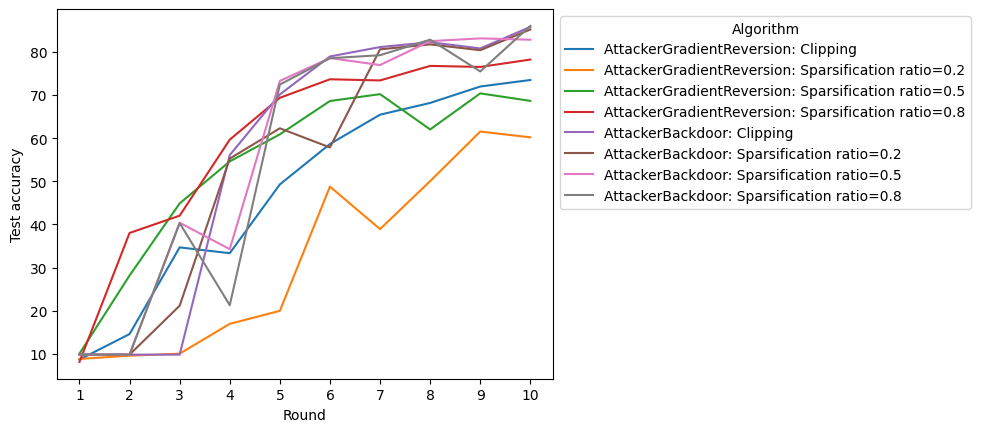

In [151]:
df = pd.concat(
    [
        fedavg_df_AttackerGradientReversion_clipping,
        fedavg_df_AttackerGradientReversion_sparsification_20,
        fedavg_df_AttackerGradientReversion_sparsification_50,
        fedavg_df_AttackerGradientReversion_sparsification_80,
        fedavg_df_AttackerBackdoor_clipping,
        fedavg_df_AttackerBackdoor_sparsification_20,
        fedavg_df_AttackerBackdoor_sparsification_50,
        fedavg_df_AttackerBackdoor_sparsification_80,
    ],
    ignore_index=True,
)
ax = sns.lineplot(df, x="Round", y="Test accuracy", hue="Algorithm", seed=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
_ = ax.set_xticks(df["Round"].unique())

TODO

### For any questions regarding this assignment, send an email to c.zhu-2@tudelft.nl